In [131]:
# %%writefile alpha_base10.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import preprocessing
from sklearn import linear_model
import tools.Pretreat_Tools as pretreat


def STD(data, windows):
    return data.rolling(window=windows, min_periods=windows).std()
def MEAN(data, windows):
    return data.rolling(window=windows, min_periods=windows).mean()
def DELTA(data, windows):
    return data.diff(4)
def SEQUENCE(n):
    return pd.Series(np.arange(1,n+1))

def SMA(data,windows,alpha):
    return data.ewm(adjust=False, alpha=float(alpha)/windows, min_periods=windows, ignore_na=False).mean()

def REGBETA(xs, y, n):
    assert len(y)>=n,  'len(y)!>=n !!!'+ str(y.index[0])
    regress = linear_model.LinearRegression(fit_intercept=False)
    def reg(X,Y):
        try:
            if len(Y)>len(X):
                Y_ =  Y[X.index]
                if Y_.isnull().any():
                    return np.nan
                res = regress.fit(X.values.reshape(-1, 1), Y_.values.reshape(-1, 1)).coef_[0]
            else:
                # if Y.isnull().any():
                #     return np.nan
                res = regress.fit(X.values.reshape(-1, 1), Y.values.reshape(-1, 1)).coef_[0]
        except Exception as e:
            print(e)
            return np.nan
        return res
    return xs.rolling(window=n, min_periods=n).apply(lambda x:reg(x,y))


def COVIANCE(A,B,d):
    se = pd.Series(np.arange(len(A.index)),index=A.index)
    se = se.rolling(5).apply(lambda x: A.iloc[x].cov(B.iloc[x]))
    return se

def CORR(A,B,d):
    se = pd.Series(np.arange(len(A.index)),index=A.index)
    se = se.rolling(5).apply(lambda x: A.iloc[x].corr(B.iloc[x]))
    return se

def excute_for_multidates(data, func, level=0, **pramas):
    return data.groupby(level=level, group_keys=False).apply(func,**pramas)



In [132]:
from tools.Cacher import (CACHE_TYPE, load_cache,load_caches_adv)
import tools.Sample_Tools as smpl
import tools.Pretreat_Tools as pretreat

%load_ext autoreload
%autoreload 2
%aimport tools.Cacher

stock_df = load_cache('all_train_qfq',cache_type=CACHE_TYPE.STOCK).sort_index()
# stock_df = pd.concat(list(map(lambda file:load_cache(file,cache_type=CACHE_TYPE.STOCK),['all_train_qfq','all_tail_qfq','all_older_qfq']))).sort_index()
ret_fs = pd.read_csv(module_path+'/data/static/china10yearbond.csv').set_index('date').sort_index()
ret_fs = (ret_fs['high']+ret_fs['low'])/2 * 0.01
ret_fs_daily = ret_fs/252
ret_fs_daily

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


date
2002-07    0.000114
2002-08    0.000113
2002-09    0.000122
2002-10    0.000122
2002-11    0.000132
             ...   
2022-09    0.000108
2022-10    0.000109
2022-11    0.000111
2022-12    0.000116
2023-01    0.000116
Length: 247, dtype: float64

In [133]:
# codes = smpl.get_codes_by_market(sse='all',only_main=True,filter_st=True)
# 

ret_t = smpl.get_current_return(stock_df,'close')
# 超额回报
ret_t_excess = ret_t.groupby(pd.Grouper(level='date', freq='1M')).apply(
        lambda x:x-ret_fs_daily.get(x.index[0][0].strftime('%Y-%m'),default=ret_fs_daily[-1]))

def cal_ret_market_daily(stock_daily_df,ret_t_excess_daily):
    ##  不取对数有时候有精度问题,权重不是精确1
    market_value_log = np.log(stock_daily_df['totalCapital'])
    market_value = market_value_log.sum()
    weight = market_value_log / market_value
    ret_market_f = (ret_t_excess_daily * weight).sum()
    return ret_market_f

# 市场收益，全市场收益加权平均
ret_market_t = ret_t_excess.groupby(level=0, group_keys=False).apply(
        lambda ret: cal_ret_market_daily(stock_df.loc[ret.index[0][0]],ret))


def camp_beta_alpha(ret_excess,ret_market):
    # 5年daily单核执行约35分钟
    
    window=252
    half_life_window = 63
    half_life_ = list(map(lambda n:0.5**(n/half_life_window),range(1,window+1)))[::-1]
    half_life_weight = half_life/np.sum(half_life)

    model = linear_model.LinearRegression(fit_intercept=True)
    res_tmp = []
    def reg(ret_t_ex):
        # print()
        # assert False,None
        res = model.fit(ret_t_ex.values.reshape(-1, 1), 
                        ret_market[ret_t_ex.index.get_level_values(0)].values.reshape(-1, 1),
                        sample_weight=half_life_weight)
        
        res_tmp.append({'date':ret_t_ex.index[-1][0],
                        'code':ret_t_ex.index[-1][1], 
                        'beta':float(res.coef_), 
                        'alpha':float(res.intercept_)})
        return 0
    
    ret_excess.dropna().groupby(level=1,group_keys=False).apply(
            lambda x:x.rolling(window).apply(reg))

    res_final = pd.DataFrame(res_tmp)
    res_final.set_index(['date', 'code'], inplace=True)
    res_final = res_final.sort_index()
    return res_final

def generat_tmpxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx():
    pd.DataFrame(res_final['beta']).reset_index().to_feather('./beta_camp.feather')
    pd.DataFrame(res_final['alpha']).reset_index().to_feather('./alpha_camp.feather')

def momentum(ret,ret_fs):
    ret_excess = ret.groupby(pd.Grouper(level='date', freq='1M')).apply(
            lambda x:np.log(1+x)-np.log(1+ret_fs.get(x.index[0][0].strftime('%Y-%m'),default=ret_fs[-1])))

    def calc_(data,window=252,half_life_window=126):
        if len(data) < 253:
            return None
        ewma = data.rolling(window).apply(
                        lambda xx:(xx.ewm(adjust=False,halflife=126).mean()[-1]))
        return ewma.rolling(11).mean().shift(11)

    mom = ret_excess.dropna().groupby(level=1,group_keys=False).apply(
                    lambda x:calc_(x))

    return mom

In [354]:


# .loc[(slice(None),ret_t.index.get_level_values(1).unique()[20:40])]
x = momentum(ret_t, ret_fs_daily)
# momentum(ret_t, ret_fs_daily)
x

date        code  
2017-01-04  000001         NaN
2017-01-05  000001         NaN
2017-01-06  000001         NaN
2017-01-09  000001         NaN
2017-01-10  000001         NaN
                        ...   
2021-12-27  605399    0.006346
2021-12-28  605399    0.005309
2021-12-29  605399    0.003428
2021-12-30  605399    0.001277
2021-12-31  605399    0.002521
Name: ret, Length: 3225766, dtype: float64

<AxesSubplot:xlabel='date'>

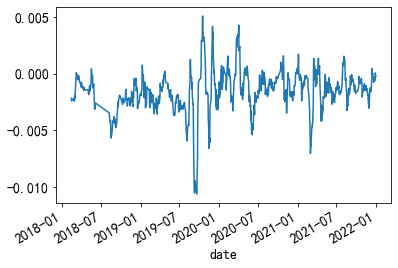

In [359]:
x.loc[(slice(None),'000008')].plot()

0.0039938178695502445

In [139]:
stock_df

open       high        low      close    volume  \
date       code                                                           
2017-01-03 000001   8.381056   8.445455   8.362656   8.427055  459840.0   
           000002  15.787499  16.041021  15.787499  15.925784  217016.0   
           000006   7.927441   8.161091   7.902406   8.069300  251674.0   
           000007  17.400000  17.533333  17.173333  17.400000   17278.0   
           000008   9.168714   9.208023   9.129406   9.178541   47814.0   
...                      ...        ...        ...        ...       ...   
2021-12-31 605580  15.584498  15.776900  15.584498  15.613359   14436.0   
           605588  39.434130  39.573543  38.946182  39.244926    3613.0   
           605589  39.430112  40.054257  37.478420  37.944052   75049.0   
           605598  16.275216  16.394960  15.876069  15.896026   38016.0   
           605599  12.685502  13.170052  12.569210  13.044069   80530.0   

                        amount       adj        shares       lshares  \
date       code                                                        
2017-01-03 000001  420595168.0  0.919984  1.430868e+06  1.219265e+06   
           000002  449757472.0  0.768248  1.103915e+06  9.709068e+05   
           000006  243074080.0  0.834467  1.349995e+05  1.344884e+05   
           000007   44872752.0  0.666667  2.309654e+04  2.059654e+04   
           000008   44600660.0  0.982713  2.809078e+05  1.495229e+05   
...                        ...       ...           ...           ...   
2021-12-31 605580   23503120.0  0.962006  2.000000e+04  5.000000e+03   
           605588   14250400.0  0.995811  7.309956e+03  1.827500e+03   
           605589  289382592.0  0.990706  7.747768e+04  8.106000e+03   
           605598   61316020.0  0.997867  1.727435e+04  4.319347e+03   
           605599  107791760.0  0.969099  7.777778e+04  7.777780e+03   

                   totalCapital  liquidity_totalCapital industry  
date       code                                                   
2017-01-03 000001  1.205800e+11            1.027481e+11    股份制银行  
           000002  1.758072e+11            1.546245e+11     住宅开发  
           000006  1.089351e+10            1.085227e+10     住宅开发  
           000007  4.018797e+09            3.583797e+09   商业物业经营  
           000008  2.578324e+10            1.372402e+10     轨交设备  
...                         ...                     ...      ...  
2021-12-31 605580  3.122672e+09            7.806679e+08     热力服务  
           605588  2.868787e+09            7.172010e+08     光学元件  
           605589  2.939817e+10            3.075745e+09     合成树脂  
           605598  2.745935e+09            6.866045e+08   其他专业工程  
           605599  1.014539e+10            1.014539e+09     钟表珠宝  

[3247889 rows x 12 columns]

In [273]:
a_l = list(range(1,21))
a = list(map(lambda n:0.5**(n/5),range(1,20+1)))#[::-1]
a_w = a/np.sum(a)
a_w
a

[0.8705505632961241,
 0.757858283255199,
 0.6597539553864471,
 0.5743491774985174,
 0.5,
 0.43527528164806206,
 0.37892914162759955,
 0.32987697769322355,
 0.2871745887492587,
 0.25,
 0.217637640824031,
 0.18946457081379978,
 0.16493848884661177,
 0.1435872943746294,
 0.125,
 0.1088188204120155,
 0.09473228540689989,
 0.08246924442330589,
 0.0717936471873147,
 0.0625]

9.80643659

In [301]:
# 2021-12-30  000001    0.004057
#             000006   -0.002394
# 2021-12-31  000001   -0.020534
#             000006    0.017987
ret_t_excess.loc[(slice(None),['000001','000006'])].groupby(level=1,group_keys=False).apply(lambda x:x.mean())

code
000001    0.000406
000006   -0.000694
Name: ret, dtype: float64